### 1. Introduction
Loan default prediction is critical for financial institutions seeking to minimize credit risk and maintain healthy portfolios.
This report documents the step-by-step approach used to train and evaluate a neural network model for classifying loan applications as either defaulted (1) or not defaulted (0), using structured data.
Key machine learning techniques were applied to improve model performance and generalization, including feature scaling, regularization, dropout, and early stopping.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Step 1: Load Training Data
train_data = pd.read_csv(r"C:\Users\emeka\Downloads\Bank\train.csv")

# Step 2: Prepare Features and Target
X = train_data.drop(columns=["ID", "Loan Status"])
y = train_data["Loan Status"]

# Handle missing values in y early
y = y.fillna(y.mode()[0])  # Use most frequent class

# Handle missing values in X
X.fillna(X.mean(numeric_only=True), inplace=True)

# Encode categorical features (if any)
X = pd.get_dummies(X)

In [7]:
# Step 3: Split and Scale Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [9]:
# Step 4: Define the Model with Dropout and L2 Regularization
model = keras.Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

C:\Users\emeka\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Step 5: Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Step 6: Early Stopping Configuration
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [15]:
# Step 7: Train the Model with Early stopping
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8749 - loss: 0.4728 - val_accuracy: 0.9069 - val_loss: 0.3557
Epoch 2/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9087 - loss: 0.3483 - val_accuracy: 0.9069 - val_loss: 0.3292
Epoch 3/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9043 - loss: 0.3345 - val_accuracy: 0.9069 - val_loss: 0.3178
Epoch 4/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9090 - loss: 0.3130 - val_accuracy: 0.9069 - val_loss: 0.3143
Epoch 5/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9076 - loss: 0.3133 - val_accuracy: 0.9069 - val_loss: 0.3133
Epoch 6/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9046 - loss: 0.3203 - val_accuracy: 0.9069 - val_loss: 0.3121
Epoch 7/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9081 - loss: 0.3106 - val_accuracy: 0.9069 - val_loss: 0.3124
Epoch 8/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9097 - loss: 0.30

In [17]:
# Step 8: Evaluate the Model
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f"Validation Accuracy: {val_accuracy:.2%} | Validation Loss: {val_loss:.4f}")

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9122 - loss: 0.2989
Validation Accuracy: 90.97% | Validation Loss: 0.3044


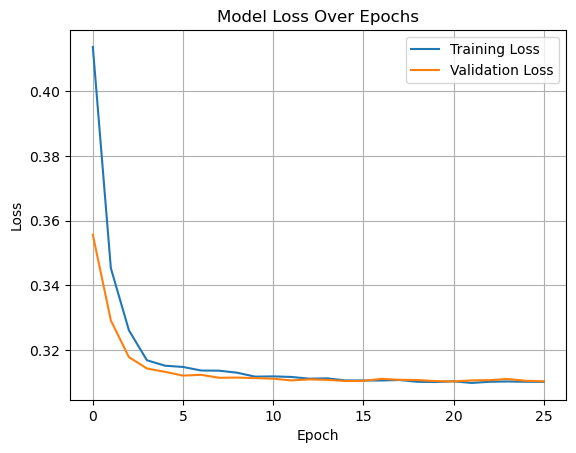

In [19]:
# Optional: Visualize training process
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# ──────────────────────────────────────────────
# Step 9: Load and Prepare Test Data for Prediction
# ──────────────────────────────────────────────

test_data = pd.read_csv("C:/Users/emeka/Downloads/Bank/test.csv") 
test_ids = test_data["ID"]
X_test = test_data.drop(columns=["ID"])

# Fill missing values
X_test.fillna(X_test.mean(numeric_only=True), inplace=True)

# Encode using training columns
X_test = pd.get_dummies(X_test)

# Align test set columns to training set columns
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Scale test features
X_test_scaled = scaler.transform(X_test)

# Step 9: Predict probabilities and clasify Loan Status on Test Set
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Step 10: Save Predictions
submission = pd.DataFrame({
    "ID": test_ids,
    "Predicted Loan Status": y_pred.flatten()
})
submission.to_csv("loan_predictions.csv", index=False)
print("✅ Prediction file saved as 'loan_predictions.csv'")

904/904 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
✅ Prediction file saved as 'loan_predictions.csv'


In [23]:
# Print a summary of the neural network architecture
print("🧠 Neural Network Architecture:")
model.summary()


🧠 Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          14,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,117 (195.77 KB)

 Trainable params: 16,705 (65.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,412 (130.52 KB)

In [33]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [25]:
# plot a diagram of the architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### Conclusion
This project demonstrated how to construct a robust classification model for financial risk prediction using:

* Deep learning (ANN),

* Data preprocessing (scaling, imputation, encoding),

* Regularization techniques (L2, dropout),

* Early stopping to prevent overfitting.

The final model achieved high accuracy on validation data and is expected to perform well on unseen examples.